In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pytz import timezone


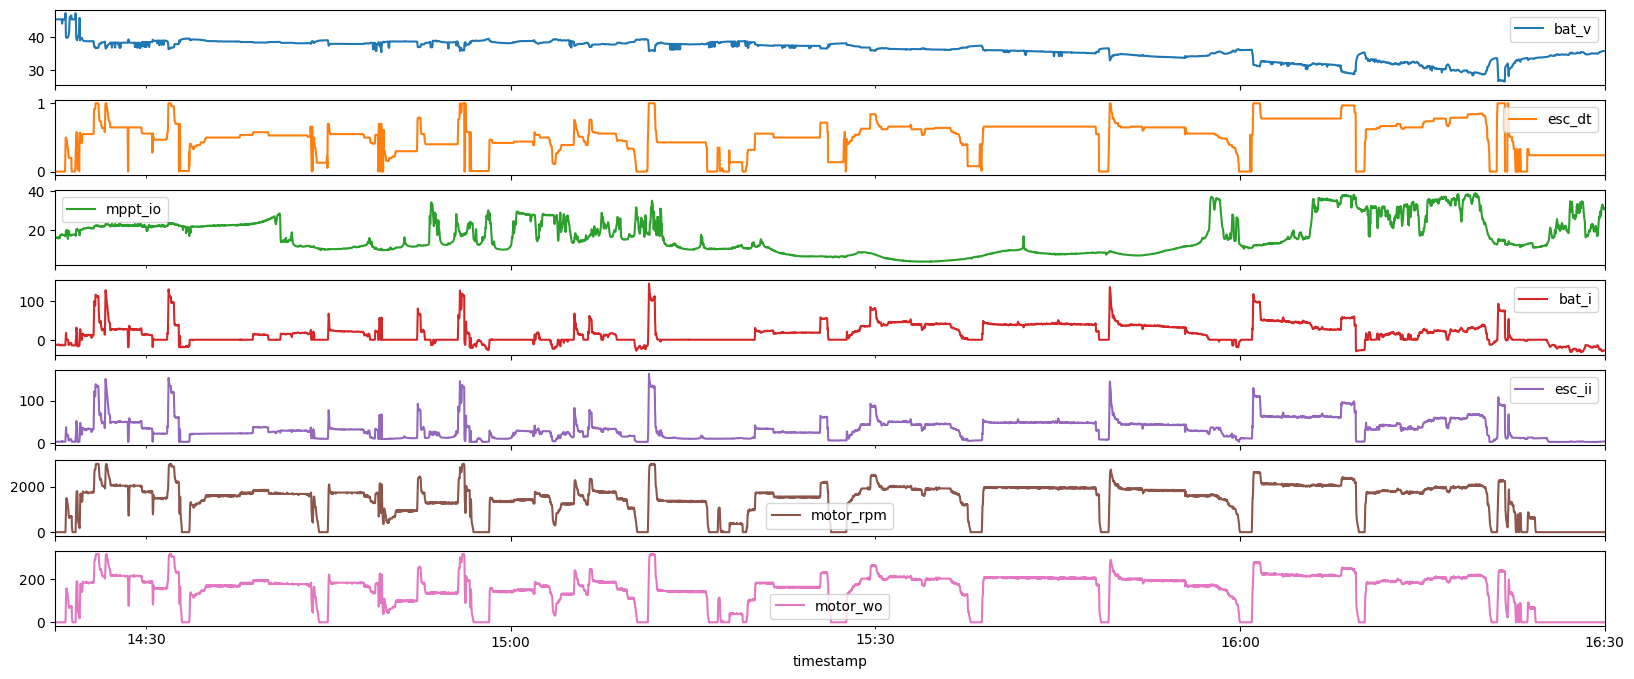

In [3]:
tzinfo = timezone("America/Sao_Paulo")
# start = pd.Timestamp(
#     year=2020, month=1, day=31, hour=12, minute=9, second=0, tzinfo=tzinfo
# ).tz_convert(None)
# end = pd.Timestamp(
#     year=2020, month=1, day=31, hour=12, minute=13, second=0, tzinfo=tzinfo
# ).tz_convert(None)

start = pd.Timestamp(
    year=2020, month=1, day=31, hour=11, minute=22, second=30, tzinfo=tzinfo
).tz_convert(None)
end = pd.Timestamp(
    year=2020, month=1, day=31, hour=13, minute=30, second=0, tzinfo=tzinfo
).tz_convert(None)

df = pd.read_csv("../../../models/2020/boat_data_1s.csv")
# df = pd.read_csv("../../../models/2020/boat_data_100ms.csv")
df["timestamp"] = pd.DatetimeIndex(df["timestamp"]).tz_convert(None)
df = df.set_index("timestamp")

df = df.loc[
    (df.index >= start) & (df.index <= end),
    ["bat_v", "esc_dt", "mppt_io", "bat_i", "esc_ii", "motor_rpm"],
]
df = df.interpolate(method="time")

rpm_to_radps = (2 * np.pi) / 60
df["motor_wo"] = df["motor_rpm"] * rpm_to_radps

df.plot(subplots=True, figsize=(20, 8))
plt.show()


In [4]:
import numpy as np
import matplotlib.pyplot as plt

import PSID
from PSID.evaluation import evalPrediction
from PSID.MatHelper import loadmat


In [5]:
T1 = (df.index - df.index[0]).to_numpy().astype(
    np.float64
) * 1e-9  # simulation time in seconds
allYData = df[["esc_dt", "bat_v"]].to_numpy()
allZData = df[["esc_ii", "motor_wo"]].to_numpy()


In [17]:
# Separate data into training and test data:
trainInds = np.arange(np.round(0.7 * allYData.shape[0]), dtype=int)
testInds = np.arange(1 + trainInds[-1], allYData.shape[0])
yTrain = allYData[trainInds, :]
yTest = allYData[testInds, :]
zTrain = allZData[trainInds, :]
zTest = allZData[testInds, :]


Behavior decoding R2:
  PSID => 0.828


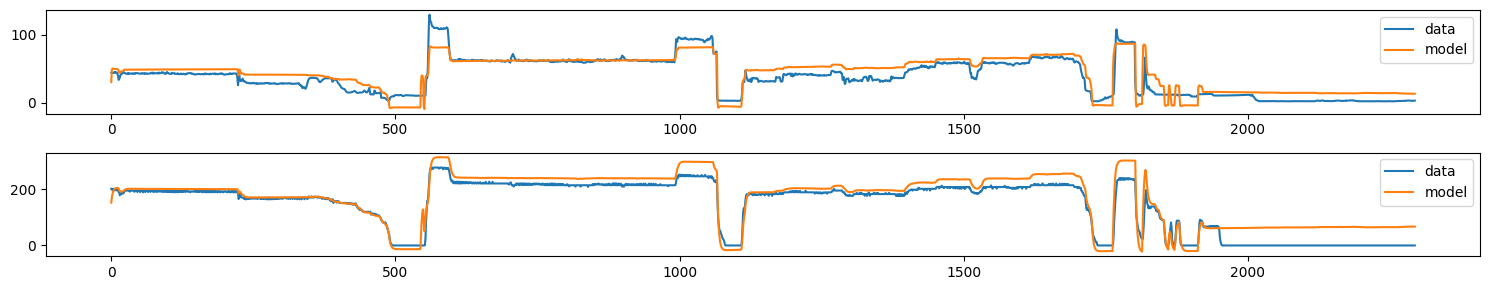

In [32]:
## (Example 1) PSID can be used to dissociate and extract only the behaviorally relevant latent states (with nx = n1 = 2)
idSys = PSID.PSID(Y=yTrain, Z=zTrain, nx=2, n1=2, i=2)

# Predict behavior using the learned model
zTestPred, _, _ = idSys.predict(yTest)

# Compute R2 of decoding
R2 = evalPrediction(zTest, zTestPred, "R2")
print("Behavior decoding R2:\n  PSID => {:.3g}".format(np.mean(R2)))

fig, ax = plt.subplots(2, figsize=(15, 3))

ax[0].plot(zTest[:, 0], label="data")
ax[0].plot(zTestPred[:, 0], label="model")
ax[0].legend(loc=1)

ax[1].plot(zTest[:, 1], label="data")
ax[1].plot(zTestPred[:, 1], label="model")
ax[1].legend(loc=1)

plt.tight_layout()
plt.show()
